In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import pairwise_distances
import phate
import scprep

os.chdir('../../src')
import mappings
import data_loader

In [2]:
def make_palette_order(labels):
    label_order = np.sort(np.unique(labels))
    
    if len(label_order) <= 10:
        pop_colors = sns.color_palette("tab10")
    else:
        pop_colors = sns.color_palette("viridis", len(label_order))

    pop_pallette = {label:color for label,color in zip(label_order, pop_colors)}
    return label_order, pop_pallette

In [3]:
# Load MHI
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/MHI'
fname = 'gsa.17k/SGR-2227_MHI_biobank_GSAv3.0MD_609343_SNPs_16707_ids_2021-01-04.WR_hg38-updated.missing10perc.noMAF0.common1000G.noHLA.raw.cols1and7toend.hdf5'
metadata_file = 'MHI_poplabels.tsv'
data_path = os.path.join(exp_path, fname)
metadata_path = os.path.join(exp_path, metadata_file)

inputs_mhi, _, samples_mhi, snp_names_mhi, _, metadata_mhi = data_loader.load_data_MHI(data_path, metadata_path)
#pca_input = pd.read_csv('/lustre06/project/6065672/shared/MHI_GWAS_SHUANG/MHI_PCA')

In [4]:
# label colors are arbitrary
label_order_mhi, pop_pallette_mhi = make_palette_order(metadata_mhi)

In [5]:
# Severely imbalanced
np.unique(metadata_mhi['selfreported_pop'], return_counts=True)

(array(['Asian', 'Black', 'Caucasian', 'Hispanic', 'Native', 'NotDone'],
       dtype=object),
 array([   66,   126, 16349,   118,     9,     4]))

In [6]:
## Load 1000G and fit PCA to it.
# On Compute Canada, Cannot load from drive! Instead load a local copy
def load_from_drive(url):
    # Download the data
    response = requests.get(url)
    data = response.content

    # Load into a DataFrame
    df = pd.read_csv(BytesIO(data))
    df.set_index('Unnamed: 0', inplace=True)
    return df

# Download data and metadata from direct download links
#inputs = load_from_drive('https://drive.google.com/uc?export=download&id=1HjK4lGImHr1WKDaz3me8Jj7FJ72S0WzL')
#labels = load_from_drive('https://drive.google.com/uc?export=download&id=1egE-5_MaCbTjQeJn6fbogcBjlXAsxSrg')
#admix_ratios = load_from_drive('https://drive.google.com/uc?export=download&id=1mYHRCkToVDa2S0cQXKlHzKHDBqb75ozC')

def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs_1K = load_from_local('../data/1000G/1000G_PCA')
labels_1K = load_from_local('../data/1000G/1000G_labels')
admix_ratios_1K = load_from_local('../data/1000G/1000G_admix_ratios')

exp_path_1K = '/lustre06/project/6065672/sciclun4/ActiveProjects/phate_genetics/data/1000G'
fname_1K = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed.hdf5'
inputs_raw_1K, _, samples_1K, snp_name_1Ks, _ = data_loader.load_data_1000G(os.path.join(exp_path_1K, fname_1K))

In [7]:
from sklearn.decomposition import PCA

# Fit PCA model
pca_1K = PCA(n_components=100)  # Number of components to keep
pca_1K.fit(inputs_raw_1K)
pca_input_1K = pca_1K.transform(inputs_raw_1K)

In [8]:
metadata_mhi['selfreported_pop']

ID
BIO-04570558-13    Caucasian
BIO-05767049-16    Caucasian
BIO-05474739-14    Caucasian
BIO-02731957-10    Caucasian
BIO-05970882-17    Caucasian
                     ...    
BIO-06013813-17    Caucasian
BIO-06020533-17    Caucasian
BIO-05583002-15    Caucasian
BIO-04671728-13    Caucasian
BIO-01338726-09    Caucasian
Name: selfreported_pop, Length: 16672, dtype: object

<Axes: title={'center': 'PCA Plot'}>

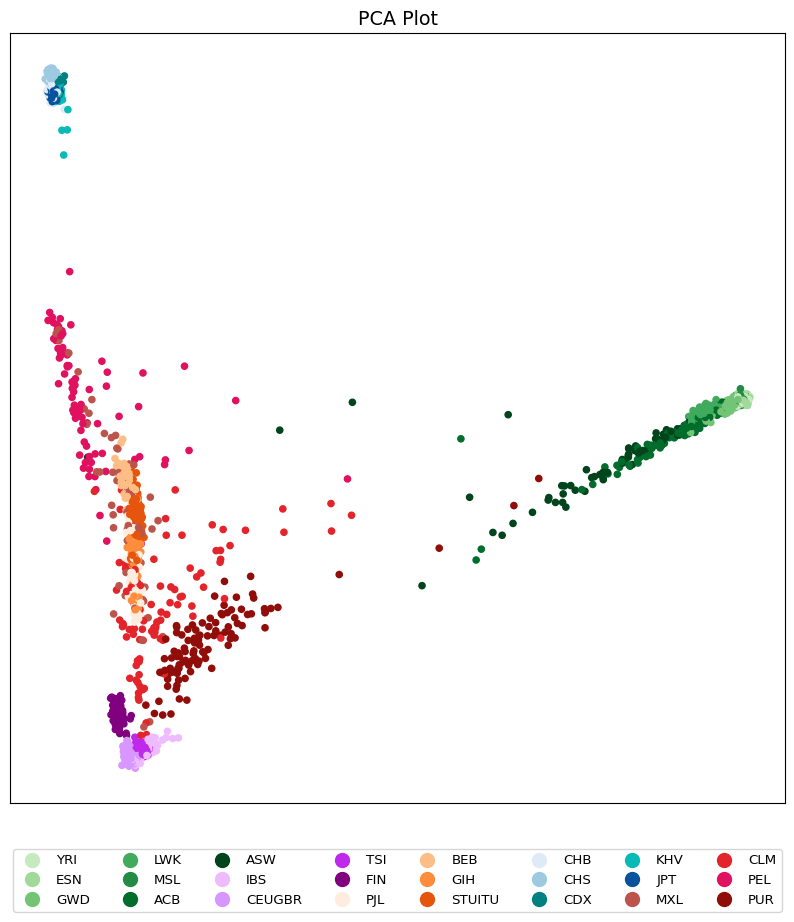

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(pca_input_1K[:, [0, 1]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

In [10]:
# Project MHI onto 1000G
pca_input_mhi = pca_1K.transform(inputs_mhi)

/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/scprep/plot/scatter.py:438: UserWarning: Cannot create a legend with constant `c=black`
  warnings.warn(


<Axes: title={'center': 'PCA Plot'}>

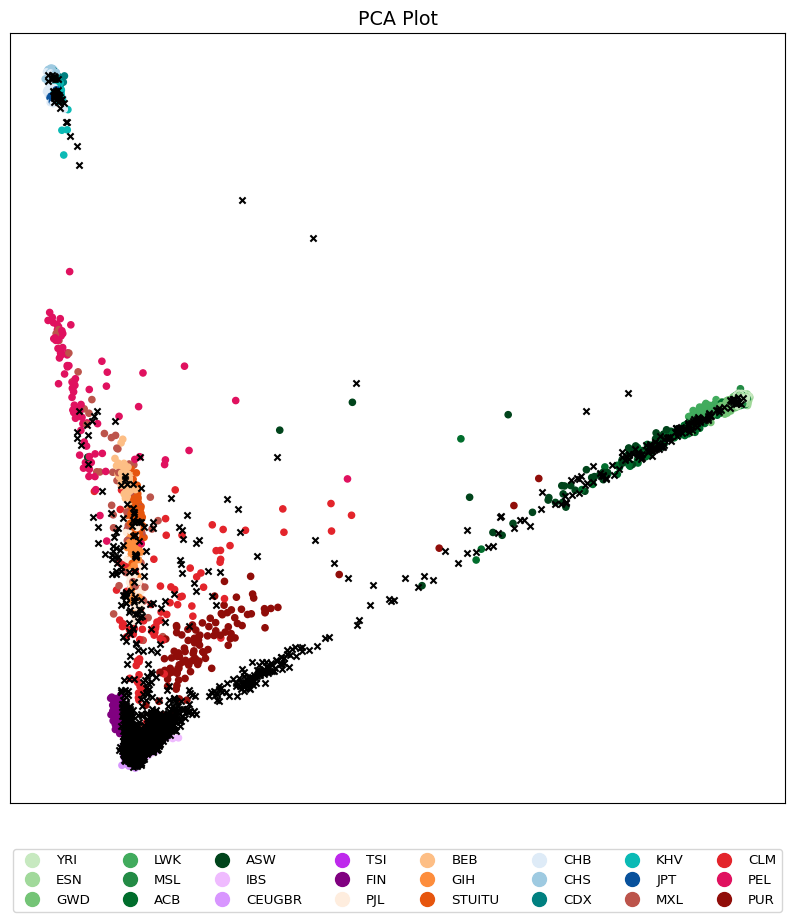

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(pca_input_1K[:, [0, 1]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

scprep.plot.scatter2d(pca_input_mhi[:, [0, 1]], c='black', marker='x', s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

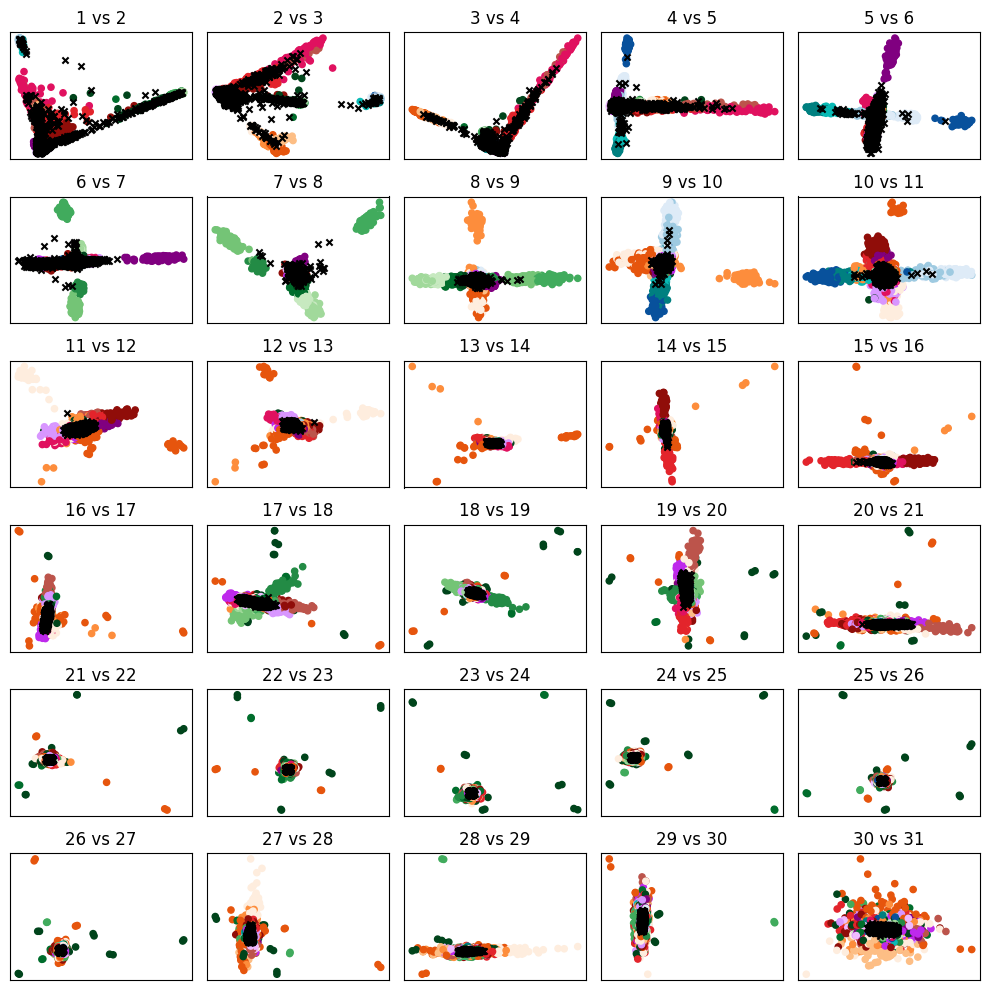

In [12]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))

comp = 1
for i in range(6):
    for j in range(5):
        scprep.plot.scatter2d(pca_input_1K[:, [comp-1, comp]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax[i,j],
                              c = labels_1K['population'], xticks=False, yticks=False,
                              legend=False, title='PCA Plot',fontsize=8)
        scprep.plot.scatter2d(pca_input_mhi[:, [comp-1, comp]], s = 20, c='black', marker='x', ax=ax[i,j],
                              xticks=False, yticks=False,
                              legend=False, title='PCA Plot')

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

plt.tight_layout()


In [16]:
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input_1K)
phate_emb_1K = phate_operator.transform(pca_input_1K)

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.38 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 0.42 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.14 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.94 seconds.
Calculated landmark operator in 2.66 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.69 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.04 seconds.


<Axes: title={'center': 'PCA Plot'}>

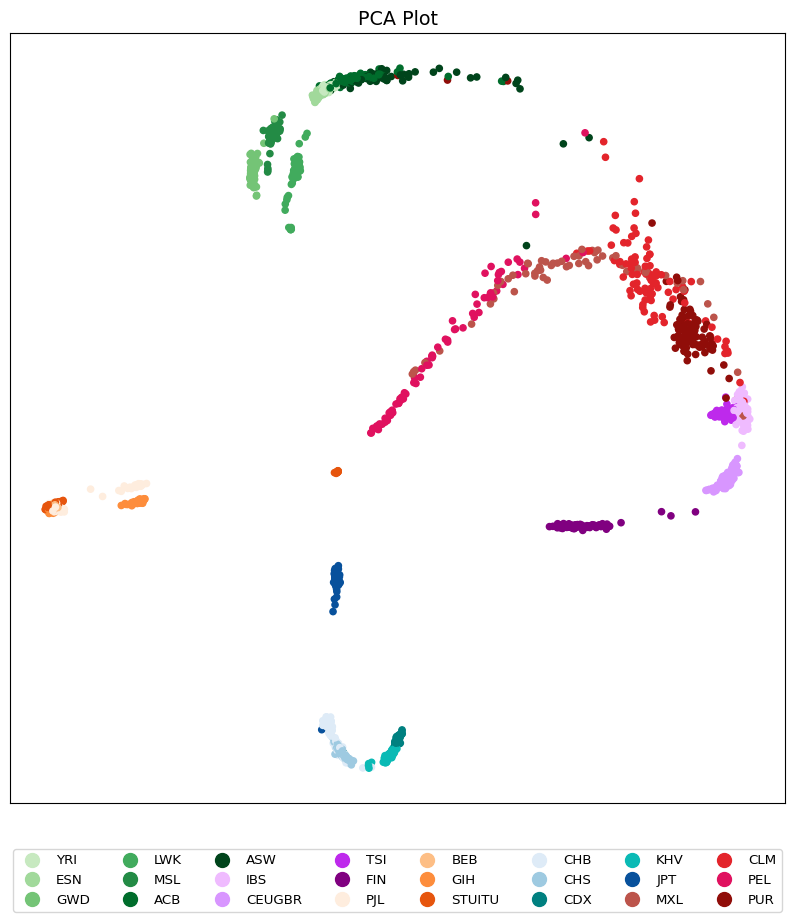

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_1K, s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

In [18]:
phate_emb_mhi = phate_operator.transform(pca_input_mhi) 

Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 2.50 seconds.
Calculating affinities...
Calculated affinities in 0.63 seconds.


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/scprep/plot/scatter.py:438: UserWarning: Cannot create a legend with constant `c=black`
  warnings.warn(


<Axes: title={'center': 'PHATE Plot'}>

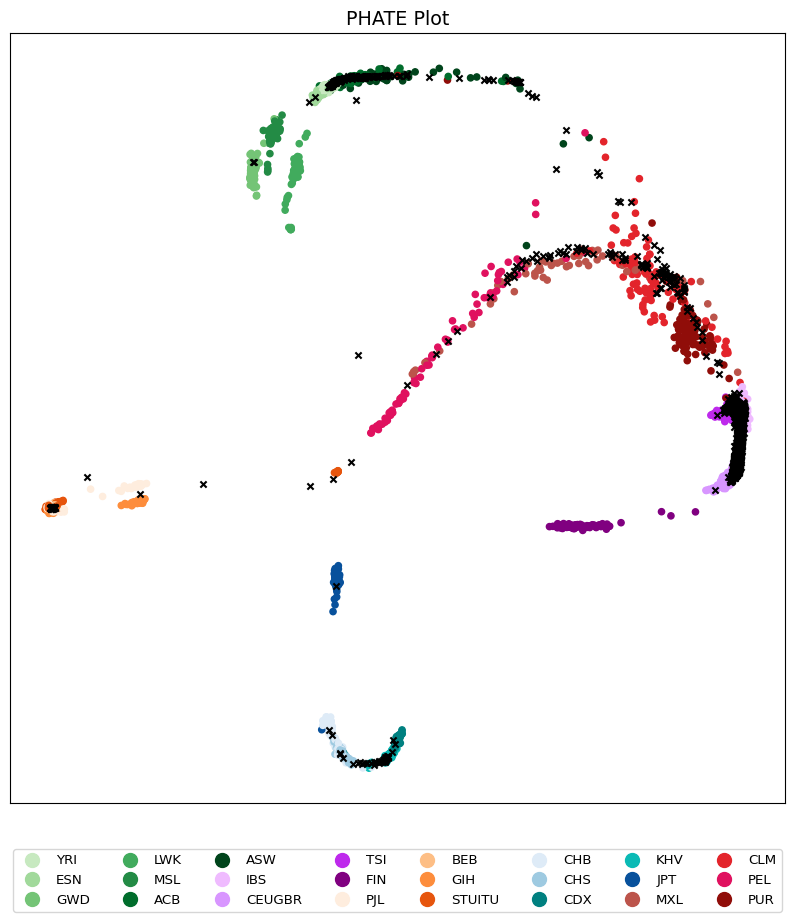

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_1K, s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

scprep.plot.scatter2d(phate_emb_mhi, c='black', marker='x', s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

In [30]:
transitions = phate_operator.graph.extend_to_data(pca_input_mhi)

Calculating KNN search...
Calculated KNN search in 2.50 seconds.
Calculating affinities...
Calculated affinities in 0.62 seconds.


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/scprep/plot/scatter.py:438: UserWarning: Cannot create a legend with constant `c=black`
  warnings.warn(


<Axes: title={'center': 'PHATE Plot'}>

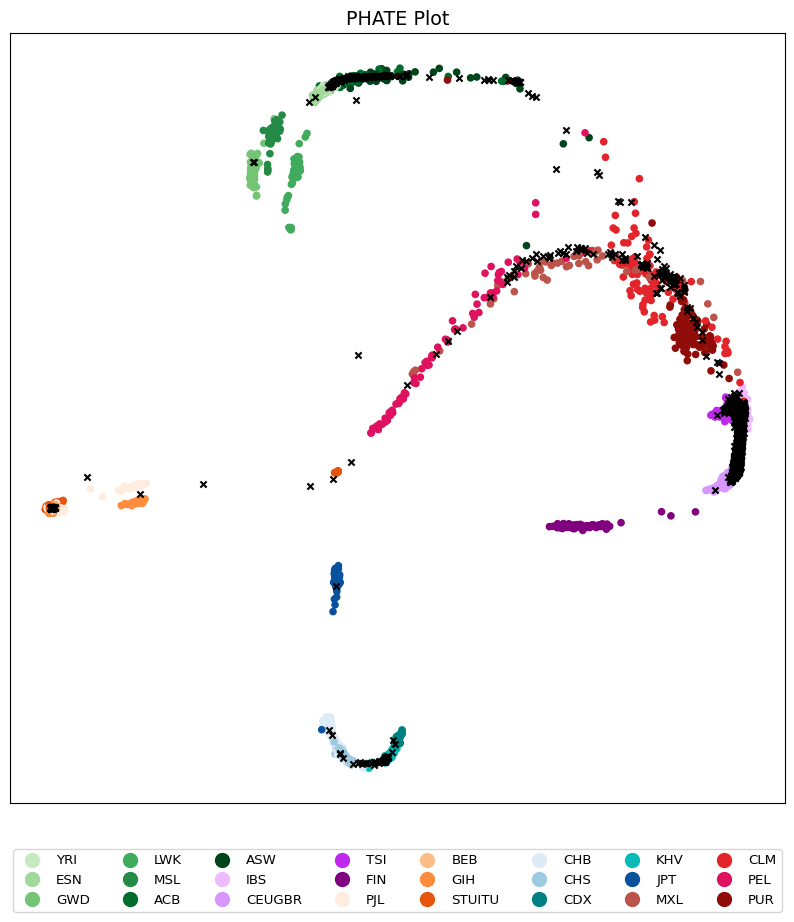

In [33]:
phate_emb_mhi2 = phate_operator.graph.interpolate(phate_operator.embedding, transitions)

fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_1K, s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

scprep.plot.scatter2d(phate_emb_mhi2, c='black', marker='x', s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

<Axes: title={'center': 'PHATE Plot'}>

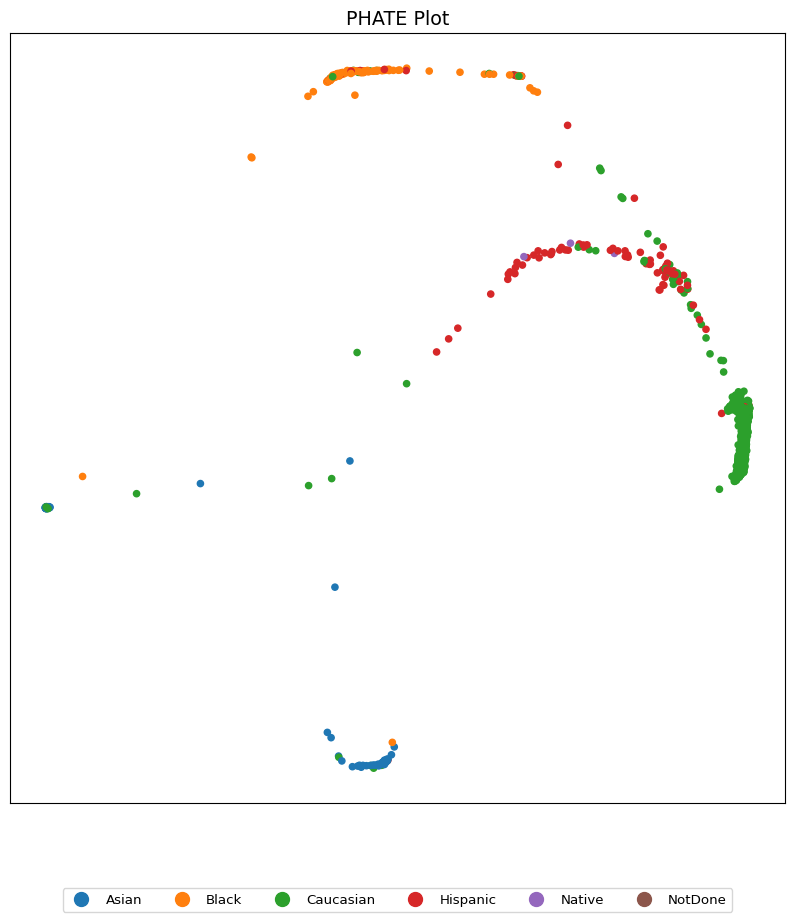

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_mhi2, c = metadata_mhi, cmap=pop_pallette_mhi, s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

In [70]:
# Fit PCA model
pca_diffusion = PCA(n_components=100)  # Number of components to keep
pca_diffusion.fit(np.array(transitions.todense()))
pca_diffusion_embs = pca_diffusion.transform(np.array(transitions.todense()))

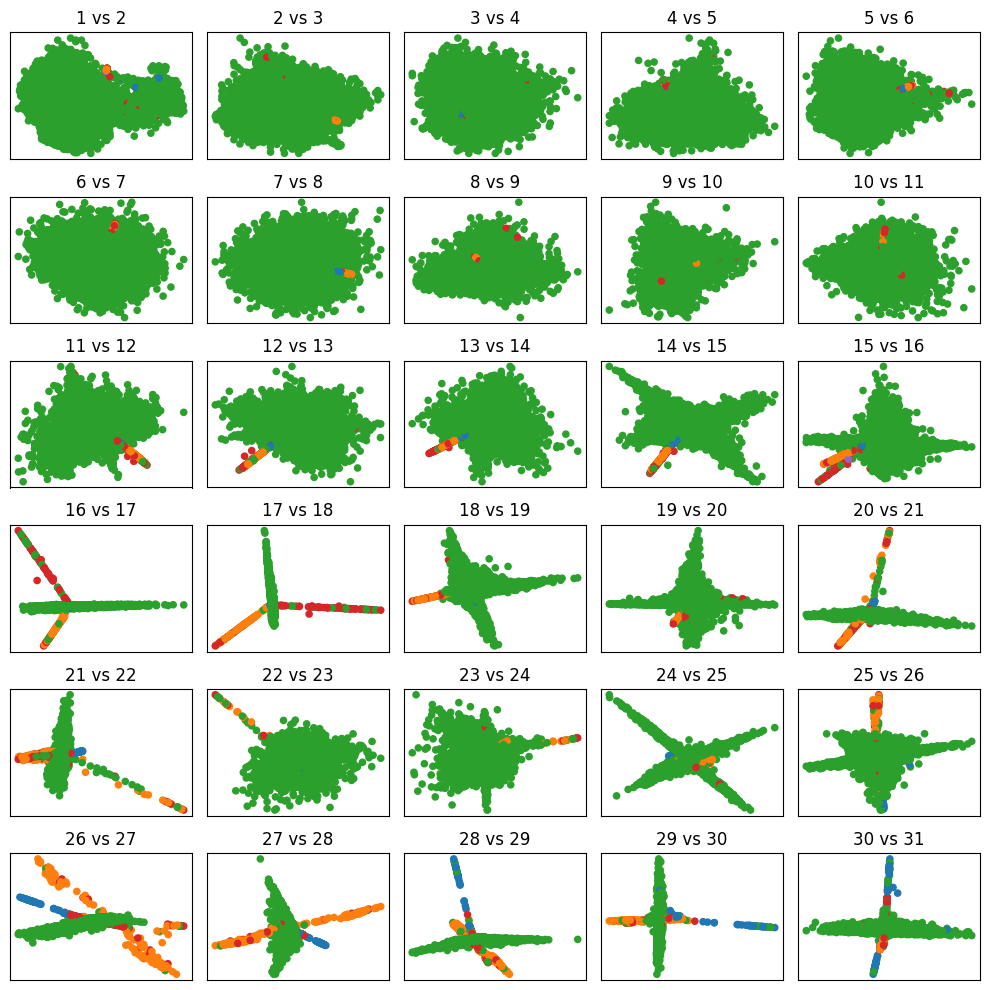

In [78]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))

comp = 1
for i in range(6):
    for j in range(5):
        scprep.plot.scatter2d(pca_diffusion_embs[:, [comp-1, comp]], s = 20, c = metadata_mhi, 
                              cmap=pop_pallette_mhi, xticks=False, yticks=False,
                              legend=False,fontsize=8, ax=ax[i,j])

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

plt.tight_layout()

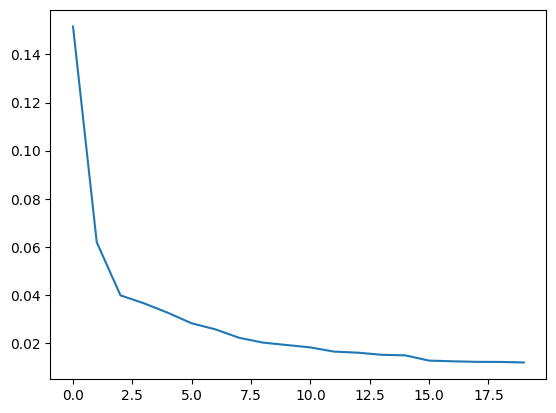

In [58]:
plt.plot(svals[:20]/svals.sum())

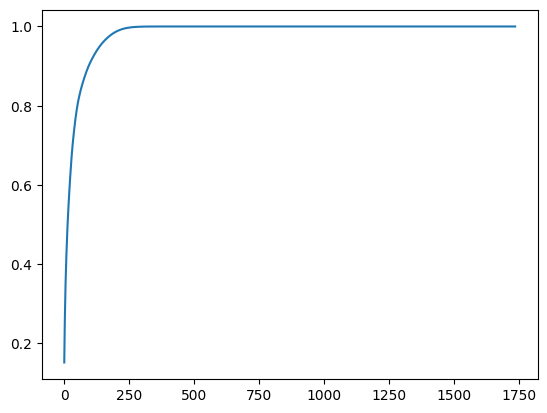

In [60]:
plt.plot((svals/svals.sum()).cumsum())

In [ ]:
svals

In [64]:
pd.DataFrame(evecs[:,:200], index=samples_mhi)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
BIO-04570558-13,-0.005679,0.001581,0.010520,0.002536,-0.011817,-0.002824,0.000209,-0.011136,-0.006134,0.016869,...,0.000010,-0.000008,-2.018080e-06,-0.000091,-4.166771e-05,1.818397e-05,1.710881e-05,0.000033,0.000011,9.725389e-06
BIO-05767049-16,-0.007950,0.004329,0.001496,-0.004338,-0.001638,0.008359,-0.006572,0.008530,0.001633,-0.000905,...,-0.000019,0.000024,1.025145e-06,-0.000090,-8.172673e-06,1.545493e-06,-3.291950e-06,-0.000068,0.001493,7.694661e-06
BIO-05474739-14,-0.006179,0.000329,0.006164,-0.000923,0.001362,0.003262,-0.003948,0.002681,-0.000808,0.010092,...,-0.000004,0.000014,5.915951e-07,-0.000088,-1.473079e-05,-8.225200e-06,-1.664676e-06,-0.000036,0.000437,4.788455e-05
BIO-02731957-10,-0.008385,-0.000051,-0.001989,-0.000130,0.001163,0.004225,-0.007364,0.006812,-0.000372,-0.001466,...,-0.000036,-0.000016,-1.915652e-06,0.000097,3.106851e-05,-2.522677e-05,-1.682816e-05,-0.000057,0.000919,6.070574e-06
BIO-05970882-17,-0.005874,-0.000201,0.005732,-0.004294,0.001079,-0.000924,0.006562,-0.003826,-0.024026,0.024356,...,0.000042,-0.000020,-1.745963e-06,-0.000047,-1.734965e-05,7.786948e-06,7.270151e-06,0.000017,0.000276,-1.693400e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BIO-06013813-17,-0.008364,-0.001287,-0.001160,-0.002847,0.004881,-0.011130,-0.013135,0.011436,-0.004261,0.003739,...,-0.000018,0.000014,3.643154e-07,-0.000057,-4.288593e-06,9.252605e-06,1.814424e-08,-0.000035,0.000544,-6.854836e-07
BIO-06020533-17,-0.007834,0.000422,0.001772,-0.004109,0.010163,-0.000698,-0.006046,0.001442,0.006728,0.005977,...,-0.000023,-0.000003,-1.842514e-06,-0.000050,-3.454259e-07,-9.605157e-08,-3.708294e-06,-0.000034,-0.000249,9.833868e-06
BIO-05583002-15,-0.008156,0.002531,0.005817,-0.005751,-0.001695,-0.009457,-0.013041,-0.003098,0.001884,-0.006424,...,0.000219,-0.000045,8.700325e-07,-0.000267,-1.180722e-04,4.607212e-05,7.870474e-05,0.000473,0.000121,2.023240e-04
BIO-04671728-13,-0.008025,-0.003126,0.007155,-0.002830,0.008910,-0.008943,-0.008795,0.006828,0.004984,-0.009954,...,0.000188,-0.000071,-6.968182e-07,-0.000122,-6.467998e-05,5.363004e-05,6.728460e-05,0.000468,0.000338,1.209228e-04


In [11]:
def plot_pca(pca_input):

    fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))

    comp = 1
    for i in range(6):
        for j in range(5):
            if (i == 5) & (j == 3):
                scprep.plot.scatter2d(pca_input[[str(comp-1), str(comp)]], ax=ax[i, j],
                                      s=5, c=metadata_mhi['selfreported_pop'], 
                                      cmap=pop_pallette_mhi,
                                      xticks=False, yticks=False, legend=True,
                                      legend_loc='upper center', legend_anchor=(-0.05, -0.05), 
                                      legend_ncol=3, fontsize=16)
            else:
                scprep.plot.scatter2d(pca_input[[str(comp-1), str(comp)]], ax=ax[i, j],
                                      s=5, c=metadata_mhi['selfreported_pop'], 
                                      cmap=pop_pallette_mhi,
                                      xticks=False, yticks=False, legend=False)

            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
            ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

            comp += 1

    plt.tight_layout()